Check out Kaggle at https://www.kaggle.com/c/lish-moa/overview, a challenge by the Laboratory of Innovation Science at Harvard. The objective is to use underlying drug characteristics to classify them into groups related to biological activity. 

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import collections
import gc
import pickle
import time
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Lambda, Flatten, Conv2DTranspose
from tensorflow.keras.layers import Dropout, GaussianNoise, Input, UpSampling2D, Concatenate
from tensorflow.keras.models import Model, Sequential, load_model
import sklearn.model_selection
from copy import deepcopy
import sklearn.metrics
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import sklearn.preprocessing
import sklearn.decomposition

<h2> STEP 1 - Data Preprocessing

In [2]:
X = pd.read_csv("./data/train_features.csv")
Y = pd.read_csv("./data/train_targets_scored.csv")
supp = pd.read_csv("./data/train_targets_nonscored.csv")
X.shape, Y.shape, supp.shape

((23814, 876), (23814, 207), (23814, 403))

In [3]:
def get_bad_cols(thresh=0.75):
    crr = X[X.columns.values[4:]].corr()
    tbl = crr.stack().reset_index()
    tbl.drop(tbl.loc[tbl.level_0==tbl.level_1].index, inplace=True)
    badcols = set()
    badvals = tbl.loc[tbl[0].apply(np.abs)>=thresh]
    while len(badvals)>0:
        vals = badvals["level_0"].append(badvals["level_1"]).value_counts()
        badcols.add(vals.index.values[0])
        badvals = badvals.loc[(badvals["level_0"]!=vals.index.values[0])&
                              (badvals["level_1"]!=vals.index.values[0])]
    newtbl = tbl.loc[(tbl.level_0.isin(list(badcols))==False)&(tbl.level_1.isin(list(badcols))==False)]
    return badcols, tbl, newtbl
badcols, tbl, newtbl = get_bad_cols(0.75)
X.drop(columns=list(badcols), inplace=True)

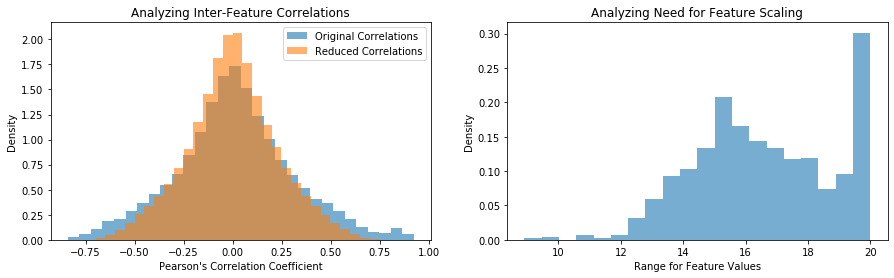

In [4]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.hist(tbl[0], bins=30, alpha=0.6, label="Original Correlations", density=True)
plt.hist(newtbl[0], bins=30, alpha=0.6, label="Reduced Correlations", density=True)
plt.legend(loc="best")
plt.xlabel("Pearson's Correlation Coefficient")
plt.ylabel("Density")
plt.title("Analyzing Inter-Feature Correlations")
plt.subplot(1,2,2)
X[X.columns.values[4:]].apply(lambda s: s.max()-s.min()).plot(kind="hist", bins=20, alpha=0.6, density=True)
plt.xlabel("Range for Feature Values")
plt.ylabel("Density")
plt.title("Analyzing Need for Feature Scaling")
plt.show()

In [5]:
pca = sklearn.decomposition.PCA(random_state=1).fit(X[X.columns.values[4:]].values[:15000])
pickle.dump(pca, open("./models/PCA.pkl","wb"))

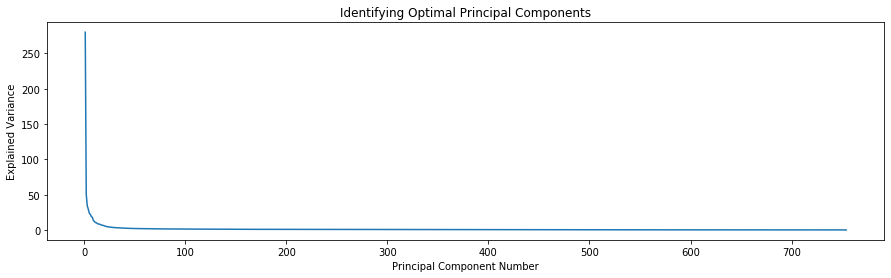

In [6]:
pca = pickle.load(open("./models/PCA.pkl","rb"))
plt.figure(figsize=(15,4))
pd.Series(pca.explained_variance_,  index=np.arange(X.shape[1]-4)+1).plot()
plt.xlabel("Principal Component Number")
plt.ylabel("Explained Variance")
plt.title("Identifying Optimal Principal Components")
plt.show()
newX = np.zeros((X.shape[0], 107))
newX[X["cp_type"]=="trt_cp",0] = 1
newX[X["cp_type"]=="ctl_vehicle",1] = 1
newX[X["cp_time"]==48,2] = 1
newX[X["cp_time"]==72,3] = 1
newX[X["cp_time"]==24,4] = 1
newX[X["cp_dose"]=="D1",5] = 1
newX[X["cp_dose"]=="D2",6] = 1
newX[:,7:] = pca.fit_transform(X[X.columns.values[4:]].values)[:,:100]
Y.drop(columns=["sig_id"], inplace=True)
np.savez('./data/clean_data.npz', X=newX, Y=Y.values, titles=Y.columns.values)

<h2> STEP 2 - Tree-Based Classifiers

In [7]:
def get_rf(dataX, dataY):
    params = {'max_depth':[3,4,5], 'min_samples_split':[2,3], 'criterion':['gini','entropy'], 
              'max_features':["auto","log2",0.8],'ccp_alpha':[0.1,0.3]}
    mdl = RandomForestClassifier(class_weight="balanced", random_state=1, n_estimators=40)
    rfmdl = RandomizedSearchCV(mdl, params, scoring=["neg_log_loss","neg_brier_score"], refit="neg_log_loss", 
                               cv=4, n_iter=8, return_train_score=True, verbose=False, random_state=1)
    rfmdl.fit(dataX, dataY)
    return rfmdl

In [8]:
nomdl = Y.apply(np.sum)
ymdl = nomdl[nomdl>10].index.values
nomdl = nomdl[nomdl<=10].index.values

In [9]:
for char in ymdl:
    mdl = get_rf(newX[:15000], Y[char].values[:15000])
    pickle.dump(mdl, open("./models/RF_"+char+".pkl","wb"))

In [59]:
modeldict = {name: pickle.load(open("./models/RF_"+name+".pkl","rb")) for name in ymdl}
def get_pred(X,Y):
    predY = np.zeros(Y.shape)
    for i in range(len(Y.columns.values)):
        if Y.columns.values[i] in ymdl:
            predY[:,i] = modeldict[Y.columns.values[i]].predict_proba(X)[:,1]
        else:
            predY[:,i] = 0
    return predY
predtestY = get_pred(newX[15000:], Y.iloc[15000:])
predtrainY = get_pred(newX[:15000], Y.iloc[:15000])

In [80]:
def neg_log_loss(t,p):
    e = np.where(p<10**(-15),10**(-15),np.where(p>(1-10**(-15)),1-10**(-15),p))
    return -np.mean(t*np.log(e)+(1-t)*np.log(1-e))
def auc_distribution(t,p, columncheck=True):
    auc = collections.deque()
    for i in range(t.shape[1]):
        if columncheck:
            if Y.columns.values[i] not in ymdl: continue
        auc.append(sklearn.metrics.roc_auc_score(t[:,i], p[:,i], average="weighted"))
    return auc
def logloss_distribution(t,p, columncheck=True):
    lloss = collections.deque()
    for i in range(t.shape[1]):
        if columncheck:
            if Y.columns.values[i] not in ymdl: continue
        lloss.append(neg_log_loss(t[:,i], p[:,i]))
    return lloss
def cleaned_pred(predtestY, predtrainY, trainY, columncheck=True):
    #Clean predtestY - if train AUC is <=0.5, replace with 0 else keep probabilities
    for i in range(trainY.shape[1]):
        if columncheck:
            if Y.columns.values[i] not in ymdl: continue
        trainauc = sklearn.metrics.roc_auc_score(trainY[:,i], predtrainY[:,i], average="weighted")
        if trainauc<=0.5:
            predtestY[:,i] = 0

In [61]:
origtestauc = auc_distribution(Y.values[15000:], predtestY)
origlogloss = logloss_distribution(Y.values[15000:], predtestY)
cleaned_pred(predtestY, predtrainY, Y.values[:15000])
newtestauc = auc_distribution(Y.values[15000:], predtestY)
newlogloss = logloss_distribution(Y.values[15000:], predtestY)

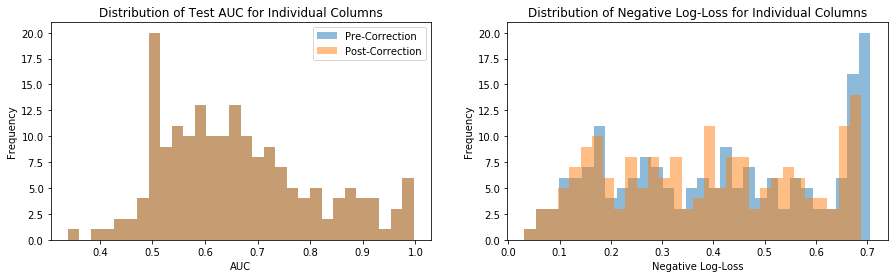

In [67]:
def plotter(origtestauc, origlogloss, newtestauc, newlogloss):
    plt.figure(figsize=(15,4))
    plt.subplot(1,2,1)
    plt.hist(origtestauc, alpha=0.5, bins=30, label="Pre-Correction")
    plt.hist(newtestauc, alpha=0.5, bins=30, label="Post-Correction")
    plt.legend(loc="best")
    plt.xlabel("AUC")
    plt.ylabel("Frequency")
    plt.title("Distribution of Test AUC for Individual Columns")
    plt.subplot(1,2,2)
    plt.hist(origlogloss, alpha=0.5, bins=30, label="Pre-Correction")
    plt.hist(newlogloss, alpha=0.5, bins=30, label="Post-Correction")
    plt.xlabel("Negative Log-Loss")
    plt.ylabel("Frequency")
    plt.title("Distribution of Negative Log-Loss for Individual Columns")
    plt.show()
plotter(origtestauc, origlogloss, newtestauc, newlogloss)

<h2> STEP 3 - Stacking Classifiers by Increasing Imbalance

In [78]:
mdls = Y.apply(np.sum).sort_values(ascending=False)
mdls = mdls[mdls>10]
for i in range(mdls.shape[0]):
    model = get_rf(newX[:15000], Y[mdls.index[i]].values[:15000])
    pickle.dump(model, open("./models/STACKRF_"+mdls.index[i]+".pkl","wb"))
    curpredY = model.predict_proba(newX)[:,1]
    newX = np.concatenate([newX, curpredY.reshape(-1,1)],axis=1)
np.savez("./data/stacked_data.npz", newX=newX, Y=Y, mdls=mdls)

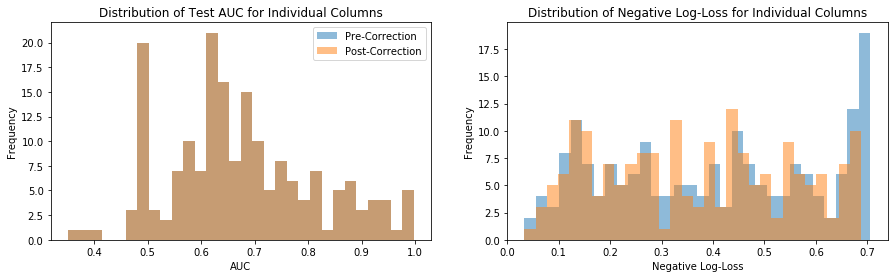

In [81]:
trainY, testY = Y[mdls.index.values].values[:15000], Y[mdls.index.values].values[15000:]
trainpred, testpred = deepcopy(newX[:15000,107:]), deepcopy(newX[15000:,107:])
origtestauc = auc_distribution(testY, testpred, False)
origlogloss = logloss_distribution(testY, testpred, False)
cleaned_pred(testpred, trainpred, trainY, False)
newtestauc = auc_distribution(testY, testpred, False)
newlogloss = logloss_distribution(testY, testpred, False)
plotter(origtestauc, origlogloss, newtestauc, newlogloss)